# Setting Up

In [ ]:
%pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 1.4 MB 47.5 MB/s 
     |████████████████████████████████| 233 kB 50.4 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394490 sha256=4138680f5e663f1344a4846346a3cdbc23dfbcbc84a43bd69ea64a056216deb0
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=153873 sha256=419b618788514fe7677fff2b93153155bd5fb70ef81e91b00229fcf0006f3284
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [ ]:
!pip install tensorflow-addons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from hazm import *
import time

## Option 1. Pick the dataset from the google drive



In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('FFFa').sheet1

rows = worksheet.get_all_values()

dataset = pd.DataFrame(rows[1:],columns=rows[0])

dataset['Id'] = pd.to_numeric(dataset['Id'])
dataset['Sentence'] = dataset['Sentence'].astype(str)
dataset['Label'] = pd.to_numeric(dataset['Label'])

## Option 2. Upload the dataset

In [ ]:
dataset = pd.read_csv('/content/sample_data/EnDataset.tsv', delimiter = '\t', quoting = 3)

In [ ]:
dataset

,Id,Sentence,Label
0,1,Chemistry is the scientific study of the prope...,0
1,2,"In the scope of its subject, chemistry occupie...",0
2,3,The word chemistry comes from a modification d...,0
3,4,The modern word alchemy in turn is derived fro...,0
4,5,The current model of atomic structure is the q...,0
...,...,...,...
23460,23461,"OI provides continuous, real-time analytics on...",16
23461,23462,If all that is needed is a glimpse at historic...,16
23462,23463,System Management mainly refers to the availab...,16
23463,23464,There is a strong relationship between complex...,16


## Mount the google drive in case we want to store a file on it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Encoding the Labels

In order to encode the labels, first we need to find out how many labels we have. To achieve this purpose, We use the following code: 

In [ ]:
labels_length = []
n = 0

for i, label in enumerate(dataset['Label']):
  if(n != label):
    if(len(labels_length) > 0):
      prior = labels_length[-1]
    else:
      prior = 0
    labels_length.append(i - prior)
    n = label

labels_length.append(len(dataset) - labels_length[-1])
label_count = len(labels_length)

print(len(labels_length))

17


In this research, we have decided to use 17 labels for our records. using the following blocks of code, we encode these labels into the proper format:

In [ ]:
y = np.zeros((len(dataset), label_count))
y.shape

(14224, 17)

In [ ]:
y[np.arange(len(dataset)), dataset['Label'].values] = 1

In [ ]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

#Text Cleansing

To clean the English & Persian paragraphs, we need to use different libraries. Therefore, We have used separate blocks of codes for them:

## Persian

In [ ]:
normalizer = Normalizer()
stemmer = Stemmer() # In case
lemmatizer = Lemmatizer()
corpus = []
is_fa = True

for i in range(0, dataset.shape[0]):
  content = re.sub('[^آ-ی‌]', ' ', dataset['Sentence'][i])
  content = normalizer.normalize(content)
  words = content.split()
  stopwords = stopwords_list()
  words = [lemmatizer.lemmatize(word) for word in words]
  words = [word for word in words if not word in stopwords]
  content = ' '.join(words)
  corpus.append(content)

## English

To cleanse the English paragraphs, we have to first install some data:

In [ ]:
nltk.download('wordnet', '/root/nltk_data/')

[nltk_data] Downloading package wordnet to /root/nltk_data/...


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!unzip /root/nltk_data/corpora/wordnet.zip

Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: wordnet/
  inflating: wordnet/lexnames        
  inflating: wordnet/data.verb       
  inflating: wordnet/index.adv       
  inflating: wordnet/adv.exc         
  inflating: wordnet/index.verb      
  inflating: wordnet/cntlist.rev     
  inflating: wordnet/data.adj        
  inflating: wordnet/index.adj       
  inflating: wordnet/LICENSE         
  inflating: wordnet/citation.bib    
  inflating: wordnet/noun.exc        
  inflating: wordnet/verb.exc        
  inflating: wordnet/README          
  inflating: wordnet/index.sense     
  inflating: wordnet/data.noun       
  inflating: wordnet/data.adv        
  inflating: wordnet/index.noun      
  inflating: wordnet/adj.exc         


Now we can start the cleansing process:

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

is_fa = False

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, dataset.shape[0]):
  content = re.sub('[^a-zA-Z]', ' ', str(dataset['Sentence'][i]))
  content = content.lower()
  words = content.split()
  words = [lemmatizer.lemmatize(word) for word in words if not word in set(stopwords.words('english'))]
  content = ' '.join(words)
  corpus.append(content)

In [ ]:
print(corpus[0])

chemistry scientific study property behavior matter natural science cover element make matter compound composed atom molecule ion composition structure property behavior change undergo reaction substance


#Creating the Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 10000)
X = cv.fit_transform(corpus).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(4693, 18) (4693, 17)
(18772, 18) (18772, 17)


In [ ]:
y_train_obj = [str(item) for item in y_train]

# Training the K-Nearest Neighbors Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

print(time.time() - start_time)

0.0359652042388916


#Training the Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import GaussianNB

start_time = time.time()
classifier = GaussianNB()
classifier.fit(X_train, y_train_obj)
print(time.time() - start_time)

2.9947898387908936


# Training the Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train_obj)
print(time.time() - start_time)

150.20131063461304


# Training the Support Vector Machine Model

In [ ]:
from sklearn.svm import SVC

start_time = time.time()
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train_obj)
print(time.time() - start_time)

1844.5621678829193


# Training the Kernel Support Vector Machine

In [ ]:
from sklearn.svm import SVC

start_time = time.time()
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train_obj)
print(time.time() - start_time)

4649.492221355438


# Training the Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)
print(time.time() - start_time)

297.12559700012207


#Training the Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'gini', random_state = 42)
classifier.fit(X_train, y_train)
print(time.time() - start_time)

14.323549509048462


# Training the Aritificial Neural Network (ANN)

## Creating the Model

In [ ]:
import tensorflow as tf
from keras.layers import Dense

model = tf.keras.models.Sequential()
act = tf.keras.activations

model.add(Dense(units=500, activation=act.relu))
# ann.add(Dense(units=68, activation=act.relu))
model.add(Dense(units=17, activation=act.softmax))

## Compiling the created model

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

## Training the Model

In [ ]:
start_time = time.time()

history = model.fit(X_train, y_train, batch_size = 100, epochs = 8)
classifier = model

print('\n total time: ' + str(time.time() - start_time) + ' seconds')

Epoch 1/8
188/188 [==============================] - 12s 62ms/step - loss: 0.8337 - categorical_accuracy: 0.8088
Epoch 2/8
188/188 [==============================] - 11s 60ms/step - loss: 0.0890 - categorical_accuracy: 0.9851
Epoch 3/8
188/188 [==============================] - 12s 62ms/step - loss: 0.0198 - categorical_accuracy: 0.9990
Epoch 4/8
188/188 [==============================] - 13s 69ms/step - loss: 0.0081 - categorical_accuracy: 0.9998
Epoch 5/8
188/188 [==============================] - 11s 61ms/step - loss: 0.0045 - categorical_accuracy: 0.9999
Epoch 6/8
188/188 [==============================] - 11s 58ms/step - loss: 0.0035 - categorical_accuracy: 0.9999
Epoch 7/8
188/188 [==============================] - 11s 60ms/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 8/8
188/188 [==============================] - 12s 62ms/step - loss: 0.0016 - categorical_accuracy: 1.0000

 total time: 93.20284748077393 seconds


## Displaying the Training process with graphs

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.7280351012945175, 1.0)

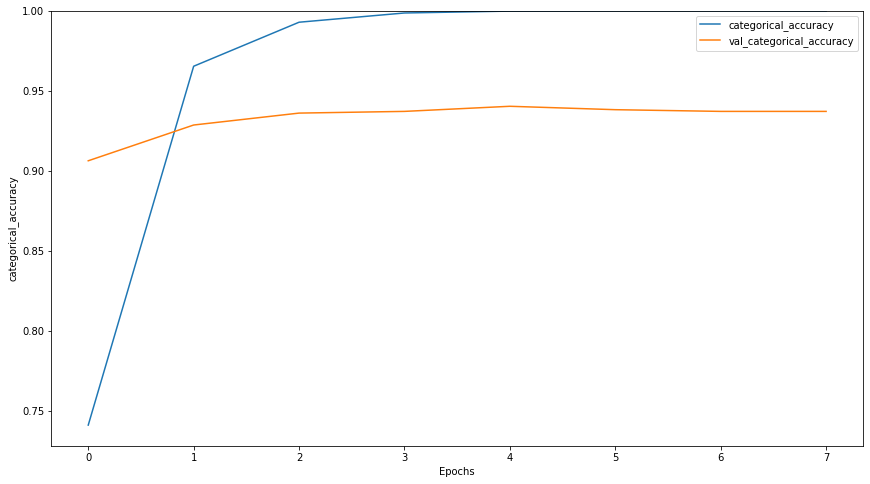

In [ ]:
plt.figure(figsize=(32, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'categorical_accuracy')
plt.ylim(None, 1)

(-0.05458163381554187, 1.3)

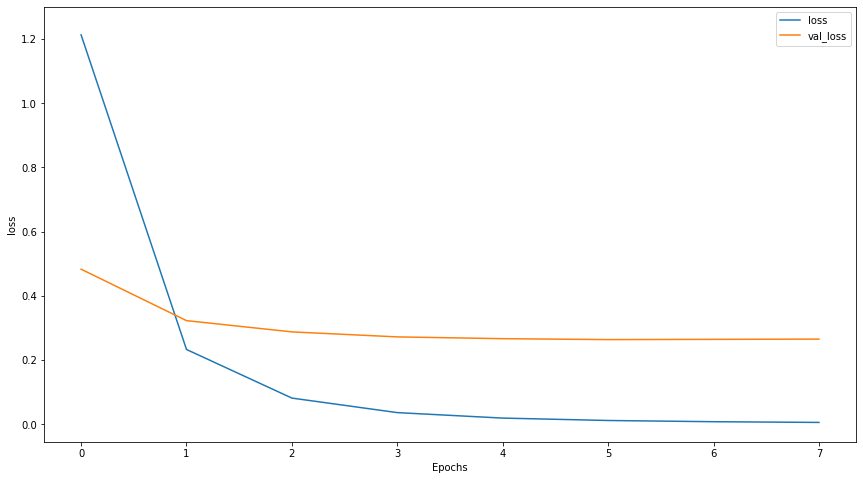

In [ ]:
plt.figure(figsize=(32, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'loss')
plt.ylim(None, 1.3)

# Training with the Recurrent Nueral Network (RNN)

To utilize the RNN model, it is required another type of word vectorizer to create the bag of words. Using the following blocks of codes, we have created a suitable tokenizer:

## Setting up the Tokenizer

### Creating the Tokenizer

In [ ]:
from keras.preprocessing import text

MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 37364 unique tokens.


### Applying the Tokenizer on the corpus

In [ ]:
from keras import utils

X = tokenizer.texts_to_sequences(corpus)
X = utils.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (14224, 250)


## Splitting the dataset

Now we have to split the dataset the same way we did for other methods:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(X_test.shape,y_test.shape)
print(X_train.shape,y_train.shape)

(2845, 250) (2845, 17)
(11379, 250) (11379, 17)


## Creating the RNN model

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D, Embedding, Bidirectional

model = tf.keras.Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Bidirectional(LSTM(50)))
# model.add(Dense(units=100, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))

## Compiling the created RNN

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the compiled RNN

In [ ]:
start_time = time.time()
history = model.fit(X_train, y_train, epochs=14, batch_size=100)
print(time.time() - start_time)

classifier = model

Epoch 1/14
114/114 [==============================] - 93s 799ms/step - loss: 2.5280 - accuracy: 0.1906
Epoch 2/14
114/114 [==============================] - 72s 632ms/step - loss: 1.5795 - accuracy: 0.4927
Epoch 3/14
114/114 [==============================] - 73s 645ms/step - loss: 1.0565 - accuracy: 0.6711
Epoch 4/14
114/114 [==============================] - 71s 623ms/step - loss: 0.7279 - accuracy: 0.7831
Epoch 5/14
114/114 [==============================] - 72s 634ms/step - loss: 0.5631 - accuracy: 0.8432
Epoch 6/14
114/114 [==============================] - 71s 619ms/step - loss: 0.6592 - accuracy: 0.8147
Epoch 7/14
114/114 [==============================] - 71s 623ms/step - loss: 0.3911 - accuracy: 0.8945
Epoch 8/14
114/114 [==============================] - 72s 630ms/step - loss: 0.3458 - accuracy: 0.9068
Epoch 9/14
114/114 [==============================] - 70s 616ms/step - loss: 0.2590 - accuracy: 0.9371
Epoch 10/14
114/114 [==============================] - 74s 639ms/step - l

#Testset pricdiction

Now we can use the created model to predict labels for the test dataset:

In [ ]:
start_time = time.time()
y_pred = classifier.predict(X_test)
duration = time.time() - start_time
print(duration)

89/89 [==============================] - 6s 59ms/step
10.683140754699707


In [ ]:
duration / len(y_test)

0.003755058261757366

## Decoding the Lables

Since we don't need the labels to be decoded anymore & for the sake of convenient comparison of predicted and actual results, we have created a function for decoding the encoded labels:

In [ ]:
def decode_one_hot(data):
  ns=[]
  for d in data:
    max = None
    for i, w in enumerate(d):
      if(max == None or max < w):
        max = w
        n = i
    ns.append(n)

  return ns

Now we can use the created function to decode the labels:

In [ ]:
if(isinstance(y_pred[0], str)):
  if(isinstance(y_pred[0], str)):
    strs = [y.replace('[', '').replace(']','').split(' ') for y in y_pred]
    decoded_y_pred = []
    for ys in strs:
      for i, y in enumerate(ys):
        if(y == '1.'):
          decoded_y_pred.append(i)
else:
  decoded_y_pred = decode_one_hot(y_pred)
  
decoded_y_test = decode_one_hot(y_test)

## Measuring the accuracy

To see the prediction & acttual results, side by side:

In [ ]:
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
for i in range(0, len(y_pred)):
  print(str(decoded_y_pred[i]) + '\t' + str(decoded_y_test[i]))

Using the following block of codes, we can calculate the overall accuracy of the models:

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(decoded_y_test, decoded_y_pred)

## Counting True/False Positive/Negetives

In [ ]:
tps = np.zeros(label_count)
tns = np.zeros(label_count)
fps = np.zeros(label_count)
fns = np.zeros(label_count)

for i in range(0, len(y_test)):
  n1 = decoded_y_test[i]
  n2 = decoded_y_pred[i]

  if(n1 == n2):
    tps[n1] += 1
    for j in range(0, label_count):
      if(j != n1):
        tns[j] += 1
  else:
    fps[n1] += 1 
    fns[n2] += 1
    for j in range(0, label_count):
      if(not(j in (n1, n2))):
        tns[j] += 1



## Displaying the the tp/tn-fp/fn in the selected google sheet file

first we set up the functions:

In [ ]:
def sum(list):
  t = 0
  for n in list:
    t += n

  return t

In [ ]:
def fill_numbers(numbers, cells: list, worksheet):
  for i, c in enumerate(cells):
    c.value = numbers[i]

  worksheet.update_cells(cells)

In [ ]:
def get_f_score(b, p, r):
  return (1 + b**2) * p * r/ (b**2 * p + r)

Now we select the google sheet file to store the results into:

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# worksheet = gc.create('model tests')
worksheet = gc.open('model results').get_worksheet(7)

In [ ]:
if(is_fa):
  cells = fill_numbers(tps, worksheet.range('C2:C18'), worksheet)
  cells = fill_numbers(tns, worksheet.range('D2:D18'), worksheet)
  cells = fill_numbers(fps, worksheet.range('E2:E18'), worksheet)
  cells = fill_numbers(fns, worksheet.range('F2:F18'), worksheet)
else:
  cells = fill_numbers(tps, worksheet.range('C48:C64'), worksheet)
  cells = fill_numbers(tns, worksheet.range('D48:D64'), worksheet)
  cells = fill_numbers(fps, worksheet.range('E48:E64'), worksheet)
  cells = fill_numbers(fns, worksheet.range('F48:F64'), worksheet)

## Calculating the Criteria

In [ ]:
tp = sum(tps)
tn = sum(tns)
fp = sum(fps)
fn = sum(fns)

precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
e_rate = 1 - accuracy
recall = tp / (tp + fn)
specificity = tn / (fp + tn)
f1 = get_f_score(1, precision, recall)
f2 = get_f_score(2, precision, recall)
f05 = get_f_score(0.5, precision, recall)

In [ ]:
print(precision)

0.8


## Displaying the Criteria in the google sheet file

In [ ]:
if(is_fa):
  cells = worksheet.range('G19:N19')
else:
  cells = worksheet.range('G65:N65')

fill_numbers([precision, recall, f1, specificity, accuracy, e_rate, f2, f05], cells, worksheet)

## Displaying the Confusion Matrix in the google sheet file

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(decoded_y_test, decoded_y_pred)

if(is_fa):
  cells = worksheet.range('B25:R41')
else:
  cells = worksheet.range('B71:R87')

fill_numbers([int(item) for item in np.concatenate(cm)], cells, worksheet)

print(cm)

[[136   6  12   1   0   1   0  11   4   0   1   0   0   2   0   3   0]
 [  9 176  14   0   0   5   2   2   7   1   1   0   1   2   1   3   0]
 [  8  12 127   0   0   5   2   1   2   0   0   0   0   0   0   1   0]
 [  0   0   0  22   1   0   0   0   0   1   0   1   1   1   0   1   0]
 [  0   0   0   1  27   3   6   1   0   1   0   0   0   1   4   3  11]
 [  4  12   8   0   5 149   1   3   0   2   2   0   1   0   2   0   1]
 [  0   6  12   1   8   6 289   0   5   0   0   0   2   2  14   3  12]
 [ 11   6   4   0   1   6   1  89   2   0   4   1   0   1   0   0   0]
 [  3   1   7   0   1   4   1   4 219   1   5   0   9   2   4   1   0]
 [  0   0   0   0   0   0   0   0   2  11   4   0   1   0   0   0   0]
 [  3   0   1   0   1   3   0   3   5   2  58   0   1   1   0   0   0]
 [  0   0   0   1   0   0   1   0   0   1   0 151   1  13   6   6   0]
 [  1   0   0   1   4   1   0   0   5   5   2   6 162   7  13   7   2]
 [  4   1   1   2   0   0   0   0   1   0   2   4   3 219   5   1   2]
 [  0 

# ~Purification

In [ ]:
# ids_test = []
# for i in range(0, len(corpus)):
#   ids_test.append(i + 1)

dataset = pd.DataFrame({'Id': dataset['Id'],
                             'Sentence': corpus, 
                             'Label': dataset['Label'].tolist(),})

dataset

,Id,Sentence,Label
0,1,شیمی فارس افغانستان فارس تاجیکستان کیمیا فرانس...,0
1,2,نمایی علم شیمی رشته فیزیک زیست‌شناس قرار گرفت#...,0
2,3,علم شیمی موضوعات چگونگی برهم‌کنش اتم مولکول طر...,0
3,4,واژه شیمی کیمیا زبان مصر باستان کیمیا واژه خام...,0
4,5,زیست‌شناس کالبدشناس اخترزیست‌شناسی بیوشیمی مهن...,0
...,...,...,...
15852,15853,بینش اجمال عملکرد تاریخ دوره زمان بود#باش راهک...,16
15853,15854,مدیریت سیستم عمدتا پا دسترس پا کارکرد زیرساخت ...,16
15854,15855,راهکار پردازش رویداد پیچیده هوش عملیاتی رابطه ...,16
15855,15856,نرم‌افزار نظارت فعالیت تجار پا فرایند کسب‌وکار...,16


In [ ]:
import pandas as pd

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('point3').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

dataset = pd.DataFrame(rows[1:],columns=rows[0])

dataset['Sentence'] = dataset['Sentence'].astype(str)
dataset['Label'] = pd.to_numeric(dataset['Label'])
dataset['Id'] = pd.to_numeric(dataset['Id'])

In [ ]:
dataset.to_csv('point4.csv')
!cp point4.csv "drive/My Drive"

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

corpus = dataset['Sentence'].tolist()
y = np.zeros((len(dataset), 17))
y[np.arange(len(dataset)), dataset['Label'].values] = 1 

blah0, ids_test, blah1, blah2 = train_test_split(dataset['Id'], y, test_size = 0.20, random_state = 42)

cv = CountVectorizer(max_features = 10000)
X = cv.fit_transform(corpus).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
ann = tf.keras.models.Sequential()
act = tf.keras.activations
ann.add(Dense(units=100, activation=act.relu))
# ann.add(Dense(units=100, activation=act.relu))
ann.add(Dense(units=17, activation=act.softmax))
ann.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
ann.fit(X_train, y_train, batch_size = 1000, epochs = 15, validation_split=0.05)

classifier = ann

Epoch 1/15
18/18 [==============================] - 4s 152ms/step - loss: 2.3303 - categorical_accuracy: 0.4906 - val_loss: 1.6974 - val_categorical_accuracy: 0.6890
Epoch 2/15
18/18 [==============================] - 3s 142ms/step - loss: 1.2516 - categorical_accuracy: 0.8129 - val_loss: 1.0075 - val_categorical_accuracy: 0.8296
Epoch 3/15
18/18 [==============================] - 3s 140ms/step - loss: 0.7085 - categorical_accuracy: 0.9101 - val_loss: 0.7013 - val_categorical_accuracy: 0.8775
Epoch 4/15
18/18 [==============================] - 3s 140ms/step - loss: 0.4464 - categorical_accuracy: 0.9494 - val_loss: 0.5494 - val_categorical_accuracy: 0.9020
Epoch 5/15
18/18 [==============================] - 3s 141ms/step - loss: 0.3034 - categorical_accuracy: 0.9693 - val_loss: 0.4661 - val_categorical_accuracy: 0.9116
Epoch 6/15
18/18 [==============================] - 3s 142ms/step - loss: 0.2174 - categorical_accuracy: 0.9810 - val_loss: 0.4159 - val_categorical_accuracy: 0.9191
Epoc

In [ ]:
y_pred = classifier.predict(X_test)

decoded_y_pred = decode_one_hot(y_pred)
decoded_y_test = decode_one_hot(y_test)
accuracy_score(decoded_y_test, decoded_y_pred)

147/147 [==============================] - 1s 6ms/step


0.9296825058597912

In [ ]:
len(dataset)

23465

In [ ]:
for i, pred in enumerate(decoded_y_pred):
 if(pred != decoded_y_test[i]):
   id = ids_test.iloc[i]
   index = dataset[(dataset['Id'] == id)].index
  #  print(str(dataset.iloc[index]) + '\t' + str(decoded_y_pred[i]) + '\t' + str(decoded_y_test[i]) + '\t' + str(i) + '\t' + str(index))
   dataset.drop(index, inplace= True)

## Relating the origin set to the pure set

In [ ]:
import pandas as pd

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
gc = gspread.authorize(creds)

worksheet = gc.open('FinalEnGood').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

dataset = pd.DataFrame(rows[1:],columns=rows[0])

dataset['Sentence'] = dataset['Sentence'].astype(str)
dataset['Label'] = pd.to_numeric(dataset['Label'])
dataset['Id'] = pd.to_numeric(dataset['Id'])

In [ ]:
worksheet = gc.open('point4').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

dataset2 = pd.DataFrame(rows[1:],columns=rows[0])

dataset2['Sentence'] = dataset2['Sentence'].astype(str)
dataset2['Label'] = pd.to_numeric(dataset2['Label'])
dataset2['Id'] = pd.to_numeric(dataset2['Id'])

In [ ]:
dataset2

,Sentence,Label,Id
0,chemistry scientific study property behavior m...,0,1
1,scope subject chemistry occupies intermediate ...,0,2
2,word chemistry come modification renaissance w...,0,3
3,modern word alchemy turn derived arabic word a...,0,4
4,current model atomic structure quantum mechani...,0,5
...,...,...,...
23845,oi provides continuous real time analytics dat...,16,25684
23846,needed glimpse historical performance specific...,16,25685
23847,system management mainly refers availability c...,16,25686
23848,strong relationship complex event processing c...,16,25687


In [ ]:
len(corpus)

26481

In [ ]:
def get_the_pures(origin_list, target_list, dataset):
  j = 0

  for i, par in enumerate(origin_list):
    if(j>=len(target_list) or par != target_list[j]):
      dataset.drop(i, inplace = True)
    else:
      j+=1

In [ ]:
pars2 = dataset2['Sentence']
j = 0

for i, par in enumerate(corpus):
  if(j>=len(pars2) or par != pars2[j]):
    dataset.drop(i, inplace = True)
  else:
    j+=1

dataset.to_csv('FFEn.csv')
!cp FFEn.csv "drive/My Drive"

In [ ]:
get_the_pures(corpus, dataset2['Sentence'], dataset)

In [ ]:
get_the_pures(dataset['Id'], dataset2['Id'], dataset)

In [ ]:
dataset

,Sentence,Label,Id,
0,Chemistry is the scientific study of the prope...,0,1,22574
1,"In the scope of its subject, chemistry occupie...",0,2,9645
2,The word chemistry comes from a modification d...,0,3,1835
3,The modern word alchemy in turn is derived fro...,0,4,9898
4,The current model of atomic structure is the q...,0,5,17306
...,...,...,...,...
26475,"OI provides continuous, real-time analytics on...",16,26476,
26476,If all that is needed is a glimpse at historic...,16,26477,
26477,System Management mainly refers to the availab...,16,26478,
26478,There is a strong relationship between complex...,16,26479,


In [ ]:
dataset.to_csv('FFEn2.csv')
!cp FFEn2.csv "drive/My Drive"

In [ ]:
dataset['Sentence']

0        Chemistry is the scientific study of the prope...
1        In the scope of its subject, chemistry occupie...
2        The word chemistry comes from a modification d...
3        The modern word alchemy in turn is derived fro...
4        The current model of atomic structure is the q...
                               ...                        
26475    OI provides continuous, real-time analytics on...
26476    If all that is needed is a glimpse at historic...
26477    System Management mainly refers to the availab...
26478    There is a strong relationship between complex...
26479    Business activity monitoring (BAM) is software...
Name: Sentence, Length: 23850, dtype: object

1. when corpus is done, cteate a dataset with corpus, labels and ids

while(accuracy < 90):
2. get x and y from the list
3. figure what happens to the ids after randomizing
4. pridict and drop the wrongs based on ids